In [3]:
# !pip install mlxtend

   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ------------------------------- -------- 1.0/1.4 MB 7.9 MB/s eta 0:00:01
   ---------------------------------------- 1.4/1.4 MB 6.9 MB/s eta 0:00:00



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [20]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

#Load the compact dataset
df = pd.read_parquet("mushroom_compact.parquet", engine="fastparquet")

cols_to_drop = [
    "cap-surface",
    "gill-attachment",
    "gill-spacing",
    "stem-root",
    "stem-surface",
    "veil-type",
    "veil-color",
    "spore-print-color",
    "cap-diameter",
    "stem-height",
    "stem-width"
]
df_fp = df.drop(columns=cols_to_drop).copy()

In [21]:
#change all categorical + target columns into item-value tokens

assoc_features = [
    "gill-color",
    "stem-color",
    "cap-color",
    "ring-type",
    "does-bruise-or-bleed",
    "habitat"]

df_fp["class_binary"] = df_fp["class"].map({"e": 1, "p":0})
#Target
target_col = "class_binary"
df_fp = df.drop(columns=cols_to_drop).copy()

assoc_features = [
    "gill-color",
    "stem-color",
    "cap-color",
    "ring-type",
    "does-bruise-or-bleed",
    "habitat"
]

df_fp["class_binary"] = df_fp["class"].map({"e": 1, "p": 0})
target_col = "class_binary"

# Make feature=value tokens
for col in assoc_features + [target_col]:
    df_fp[col] = col + "=" + df_fp[col].astype(str)

#keep ONLY the assoc features+target
df_fp = df_fp[assoc_features + [target_col]].copy()

#Sample
df_fp_sample = df_fp.sample(n=50000, random_state=42)

#transactions -> True/False
from mlxtend.preprocessing import TransactionEncoder

transactions = df_fp_sample.values.tolist()
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_transactions = pd.DataFrame(te_ary, columns=te.columns_)


In [29]:
#optimized FPGrowth
from mlxtend.frequent_patterns import fpgrowth

frequent_itemsets = fpgrowth(
    df_transactions,
    min_support=0.02, #appears in at least 2% of sample
    use_colnames=True,
       max_len=2 #no huge combos

    
)


In [30]:
df_transactions.shape, frequent_itemsets.shape


((50000, 58), (243, 2))

In [31]:
#generatre rules
from mlxtend.frequent_patterns import association_rules
rules = association_rules(frequent_itemsets,metric="confidence", min_threshold=0.8)
rules.shape
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(ring-type=f),(does-bruise-or-bleed=f),0.78812,0.82552,0.64876,0.823174,0.997158,1.0,-0.001849,0.986733,-0.013271,0.672374,-0.013445,0.804527
1,(class_binary=0),(does-bruise-or-bleed=f),0.54728,0.82552,0.45434,0.830178,1.005643,1.0,0.002549,1.027431,0.012395,0.494676,0.026698,0.690273
2,(stem-color=w),(does-bruise-or-bleed=f),0.37914,0.82552,0.30654,0.808514,0.979400,1.0,-0.006448,0.911189,-0.032768,0.341313,-0.097467,0.589922
3,(does-bruise-or-bleed=t),(habitat=d),0.17448,0.71598,0.14684,0.841586,1.175433,1.0,0.021916,1.792902,0.180795,0.197466,0.442245,0.523338
4,(habitat=g),(does-bruise-or-bleed=f),0.13370,0.82552,0.12264,0.917277,1.111151,1.0,0.012268,2.109220,0.115471,0.146597,0.525891,0.532919


In [32]:
#filter class rules
rules_class = rules[rules['consequents'].apply(lambda c: any("class_binary=" in item for item in c) )]

rules_class = rules_class.sort_values(by=["lift", "confidence"],ascending=False)

rules_class.head(20)



,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
45,(ring-type=z),(class_binary=0),0.03782,0.54728,0.03782,1.000000,1.827218,1.0,0.017122,inf,0.470515,0.069105,1.000000,0.534553
33,(cap-color=r),(class_binary=0),0.02842,0.54728,0.02480,0.872625,1.594476,1.0,0.009246,3.554227,0.383741,0.045017,0.718645,0.458970


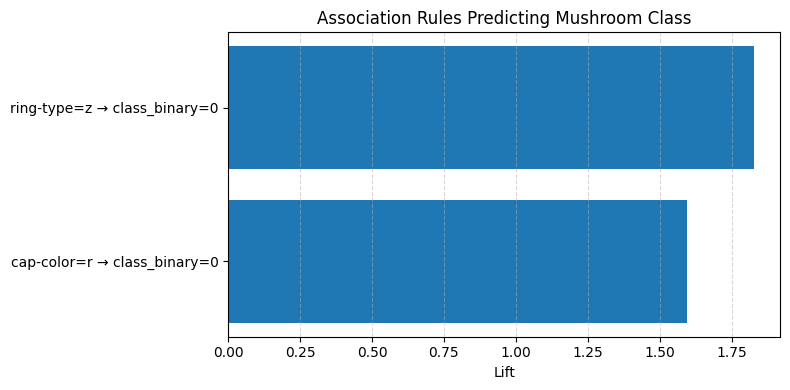

In [33]:
import matplotlib.pyplot as plt

# Make a copy of the class rules
rules_plot = rules_class.copy()

# Create a readable text label for each rule
def format_rule(row):
    ant = ", ".join(row["antecedents"])
    cons = ", ".join(row["consequents"])
    return f"{ant} → {cons}"

rules_plot["rule"] = rules_plot.apply(format_rule, axis=1)

# Sort by lift (strongest first)
rules_plot = rules_plot.sort_values(by="lift", ascending=True)  # ascending for nice barh order

# Plot lift for each rule
plt.figure(figsize=(8, 4))
plt.barh(rules_plot["rule"], rules_plot["lift"])
plt.xlabel("Lift")
plt.title("Association Rules Predicting Mushroom Class")
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()
